In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from skopt import BayesSearchCV
from skopt.space import Real


In [3]:
# 数据加载
df = pd.read_csv('data.csv')

# 特征选择
df.drop(columns=['street_name', 'listing_id', 'property_id', 'plan_no', 'extract_date', 'result_count', 'details_url', 'description', 'short_description', 'bullet_list', 'price_change', 'price_change_percent_list', 'price_change_date_list', 'price_change_direction_list', 'price_change_summary_percent', 'price_change_summary_direction', 'price_change_summary_last_updated_date', 'first_marketed_date', 'last_marketed_date', 'property_number', 'category', 'num_floors', 'displayable_address', 'agent_address', 'agent_postcode', 'agent_name', 'agent_logo', 'listing_status', 'status', 'branch_id', 'image_url', 'thumbnail_url', 'image_caption', 'original_image_list', 'other_image_list', 'other_image_desc_list', 'document_list', 'epc_list', 'virtual_tour_list', 'floor_plan_list'], inplace=True)
df.dropna(inplace=True)

# 数据清洗
df['ttwa11nm'] = df['ttwa11nm'].astype('category')
df['ttwa11cd'] = df['ttwa11cd'].astype('category')
df['outcode'] = df['outcode'].astype('category')
df['incode'] = df['incode'].astype('category')
df['property_type'] = df['property_type'].astype('category')
df['county'] = df['county'].astype('category')
df['country'] = df['country'].astype('category')
df['post_town'] = df['post_town'].astype('category')


In [4]:
num_features = ['num_bedrooms', 'num_bathrooms', 'num_recepts']
cate_features = ['ttwa11nm', 'outcode', 'incode', 'property_type', 'county', 'post_town']

# 1. 数值特征的异常值处理
for feature in ['num_bedrooms']:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 裁剪异常值
    df = df[(df[feature] <= upper_bound)]

# # 2. 类别特征的异常值处理
# for feature in cate_features:
#     # 计算每个类别的出现次数，并筛选出现次数超过1%的类别
#     counts = df[feature].value_counts()
#     threshold = 0.005 * len(df)
#     to_keep = counts[counts > threshold].index
#     df = df[df[feature].isin(to_keep)]

# 目标编码
encoder = TargetEncoder()
df[cate_features] = encoder.fit_transform(df[cate_features], df['price'])

df.shape


(8664, 12)

In [4]:
# import pandas as pd

# # 加载数据
# df = pd.read_csv('data.csv')

# # 类别特征列表
# cate_features = ['ttwa11nm', 'ttwa11cd', 'outcode', 'incode', 'property_type', 'county', 'post_town']

# # 设置pandas的显示选项，以便完整显示所有数据
# pd.set_option('display.max_rows', None)  # 允许完全显示所有行
# pd.set_option('display.max_columns', None)  # 允许完全显示所有列
# pd.set_option('display.width', None)  # 自动调整显示宽度
# pd.set_option('display.max_colwidth', None)  # 允许列宽完全显示数据

# # 查看每个类别特征的类别样本数量占比
# for feature in cate_features:
#     print(f"类别分布比例 - {feature}:")
#     # 计算各类别的百分比
#     category_dist = df[feature].value_counts(normalize=True) * 100
#     # 打印结果
#     print(category_dist)
#     print("\n")  # 添加空行以便于阅读


In [5]:
# 重置原始 DataFrame 索引
df = df.reset_index(drop=True)

# 数据标准化
scaler = StandardScaler()
# encoder = OneHotEncoder()
encoder = OneHotEncoder(sparse_output=True)

# 对数值特征进行标准化
X_scaler = scaler.fit_transform(df[num_features+cate_features])
X_scaler = pd.DataFrame(X_scaler, columns=num_features+cate_features)

# 合并哈希后的特征和数值特征
X_final = X_scaler

# 准备数据
X = X_final
y = df['price']

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 高斯过程回归模型
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 拟合模型
gpr.fit(X_train, y_train)

# 预测
y_pred, sigma = gpr.predict(X_test, return_std=True)

# 打印均值和标准差
print("Predictions:", y_pred)
print("Uncertainty:", sigma)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing 

Predictions: [    0.            0.            0.        ...     0.            0.
 59949.9999994]
Uncertainty: [3.16227766e+00 3.16227766e+00 3.16227766e+00 ... 3.16227766e+00
 3.16227766e+00 1.00000892e-05]


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)


MSE: 77690873448.43434
RMSE: 278730.8261538977
MAE: 178983.32766517834
R² Score: -0.7143718258982716


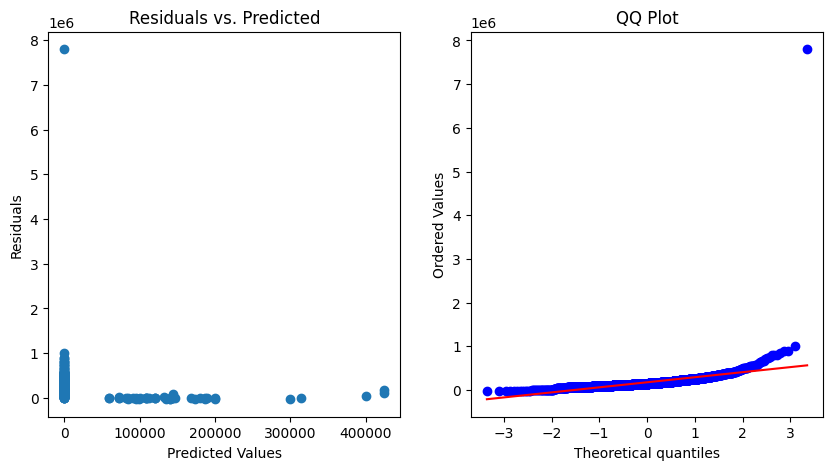

In [8]:
import matplotlib.pyplot as plt
import scipy.stats as stats

residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')
plt.show()


In [6]:
from sklearn.model_selection import cross_val_score

# 使用交叉验证来评估模型
# X_scaled 是输入特征，y 是目标变量
# gpr 是之前定义的高斯过程回归模型
cross_val_r2_scores = cross_val_score(gpr, X_scaler, y, scoring='r2', cv=5)

# 打印每次折叠的R² Score和平均R² Score
print("CV R² Scores:", cross_val_r2_scores)
print("Average CV R² Score:", cross_val_r2_scores.mean())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing 

CV R² Scores: [-2.33787545 -2.41889482 -2.72408233 -0.50440793 -2.59985683]
Average CV R² Score: -2.117023470674301


In [9]:
# 使用GridSearchCV
param_grid = {
    "kernel": [C(1.0, (1e-3, 1e1)) * RBF(length_scale) for length_scale in np.logspace(-3, 2, 10)]
}
grid_search = GridSearchCV(gpr, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing t

Best parameters: {'kernel': 1**2 * RBF(length_scale=27.8)}


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# grid_search最优模型
best_gpr1 = grid_search.best_estimator_

# 使用最优模型在测试集上进行预测
y_pred_gs = best_gpr1.predict(X_test)

# 计算 R^2 值
r2_gs = r2_score(y_test, y_pred_gs)
print(f'R^2 Score: {r2_gs}')


R^2 Score: -0.7143718261092962
